In [1]:
import pytesseract
import numpy as np
import re
import csv
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph

# Image processing 

In [52]:
import cv2

# Load the image
image_path = "Fine3.jpeg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


In [53]:
# Function to enhance image quality
def enhance_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ensure the grayscale image is in the correct data type (8-bit unsigned integer)
    gray = np.uint8(gray)
    
    # Apply adaptive thresholding to separate background from text
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the thresholded image
    thresholded = cv2.bitwise_not(thresholded)
    
    # Sharpen the image
    kernel = np.array([
        [-1, -1, -1],
        [-1, 12, -1],  # Increase center weight
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    return sharpened

# Enhance the image quality
enhanced_image = enhance_image(image)


##### Denoiser 

In [61]:
import numpy as np

def denoise_image(enhanced_image):
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

denoised_image = denoise_image(enhanced_image)


KeyboardInterrupt: 

# Check Difference 

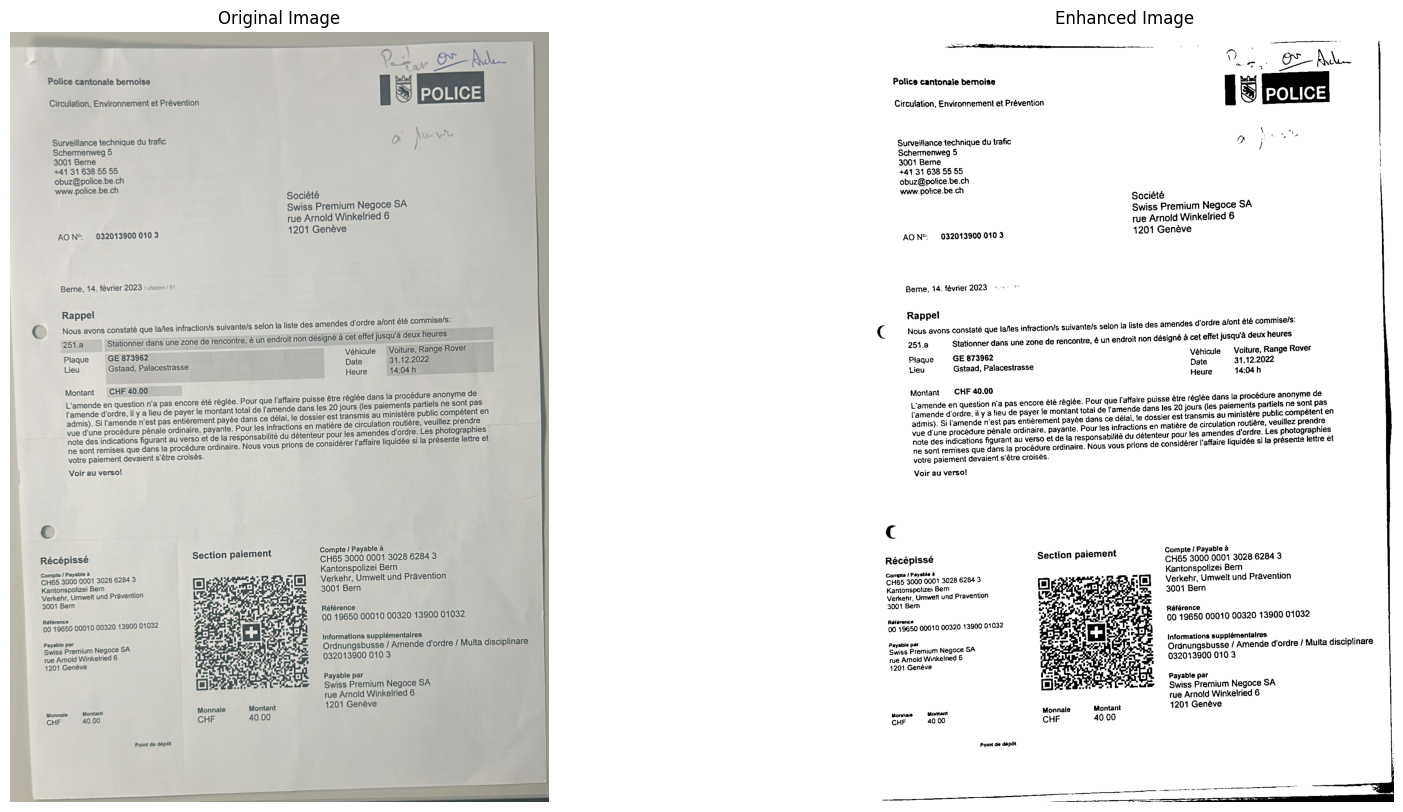

In [54]:
# Plot the original and enhanced images
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')
plt.savefig('original_and_enhanced_images.png')
plt.show()

In [ ]:
# Define a filename for the image to be saved
output_filename = 'enhanced_image.png'
# Ensure the enhanced_upscaled_image numpy array is correctly formatted
# with pixel values in the range [0, 1] before saving.
# If the values are within [0, 255], remove the multiplication by 255.
enhanced_upscaled_image_to_save = (enhanced_upscaled_image * 255).astype(np.uint8) if enhanced_upscaled_image.max() <= 1.0 else enhanced_upscaled_image
# Save the image using OpenCV
cv2.imwrite(str(current_dir / output_filename), enhanced_upscaled_image_to_save)
print(f"Image saved as {output_filename} in the current directory")

# Extract Text 

### 1.Detect Language

#### Identifying relevant text only 

Detected language: fr


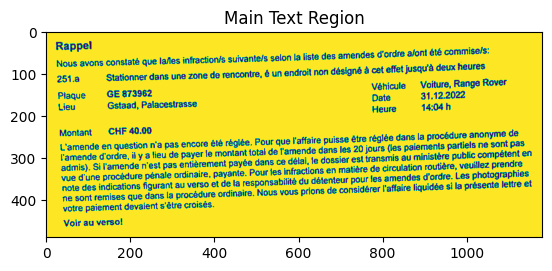

In [57]:
import numpy as np
import cv2
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

import langdetect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(image):
    try:
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        text = pytesseract.image_to_string(image)
        language = langdetect.detect_langs(text)
        # Return the most probable language
        return language[0].lang
    except LangDetectException as e:
        print("Language detection error:", e)
        return None

# Now, determine the language of the document image
language = detect_language(enhanced_image)

if language:
    print("Detected language:", language)
    # Based on detected language, set Tesseract configuration
    if language == 'fr':
        config = '--psm 4 -l fra'
    elif language == 'de':
        config = '--psm 4 -l deu'
    elif language == 'it':
        config = '--psm 4 -l ita'
    else:
        print("Unsupported language detected.")
        config = ''
        
    # If a supported language is detected, proceed with text extraction
    if config:
        def find_densest_text_area(image, config):
            if isinstance(image, np.ndarray):
                image = Image.fromarray(image)
            
            image_np = np.array(image)
            data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
            box_map = np.zeros(image_np.shape[:2], dtype=np.uint8)

            for i in range(len(data['text'])):
                if int(data['conf'][i]) > 60:
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    box_map[y:y+h, x:x+w] += 1

            kernel_size = 50 # Increase kernel size for more aggressive merging
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            box_map_dilated = cv2.dilate(box_map, kernel, iterations=1)

            threshold_value = np.max(box_map_dilated) * 0.4  # Lower the threshold slightly
            _, box_map_thresholded = cv2.threshold(box_map_dilated, threshold_value, 255, cv2.THRESH_BINARY)

            contours, _ = cv2.findContours(box_map_thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                print("No dense text areas detected.")
                return None

            img_center_x, img_center_y = image.width // 2, image.height // 2
            max_score = 0
            best_rect = None
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                area = w * h
                center_x, center_y = x + w // 2, y + h // 2
                distance = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
                score = area / (distance + 1)  # Increased weight to area

                if score > max_score:
                    max_score = score
                    best_rect = (x, y, w, h)

            if not best_rect:
                print("No suitable area found.")
                return None

            x, y, w, h = best_rect
            densest_area = image.crop((x, y, x + w, y + h))

            return densest_area

        # Convert upscaled numpy array back to PIL Image
        enhanced_upscaled= Image.fromarray(enhanced_image)

        # Now, find the densest text area in the upscaled image
        relevant_text_image = find_densest_text_area(enhanced_upscaled, config)
        if relevant_text_image:
            # Display the main text region image
            plt.imshow(relevant_text_image)
            plt.title('Main Text Region')
            plt.show()
        else:
            print("No text region was extracted.")
    else:
        print("Language detection failed.")


### Extracting relevant text 

In [58]:
import torch
import doctr
from PIL import Image
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import tempfile

# Assuming relevant_text_image is already defined

# Save the relevant_text_image to a temporary file
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_file:
    relevant_text_image.save(temp_file.name)

    # Create a DocumentFile object from the temporary file
    single_img_doc = DocumentFile.from_images([temp_file.name])

# Instantiate a pretrained OCR model
model = ocr_predictor(pretrained=True)

# Use the model to analyze the document
result = model(single_img_doc)


In [59]:
# Initialize densest_text variable to store the entire extracted text
densest_text = ""

# Iterate through the OCR result to extract and accumulate the text
for page in result.pages:
    for block in page.blocks:
        for line in block.lines:
            # Extract the text from the line
            line_text = ' '.join([word.value for word in line.words])
            
            # Append the line text to densest_text, with a newline character for separation
            densest_text += line_text + "\n"

# Print the entire extracted text
print("Entire Extracted Text:")
print(densest_text)


Entire Extracted Text:
Rappel
suivante/s selon la liste des amendes d'ordre alont été commise/s:
Nous avons constaté que lalles infraction/s
deux heures
Stationner dans une zone de rencontre, é un endroit non désigné à cet effet jusqu'à
251.a
Véhicule Voiture, Range Rover
Plaque
Lieu
GE 873962
Date
Heure
31.12.2022
14:04 h
Gstaad, Palacestrasse
Montant CHF 40.00
dans la procédure anonyme de
n'a
encore été réglée. Pour que l'affaire puisse être réglée
L'amende en question pas
dans les 20 jours (les paiements partiels ne sont pas
l'amende d'ordre, il y a lieu de payer le montant total de l'amende dossier est transmis au ministère public compétent en
admis). Si l'amende n'est pas entièrement payée dans ce délai, le
matière de circulation routière, veuillez prendre
ordinaire, payante. Pour les infractions en
vue d'une procédure pénale
du détenteur pour les amendes d'ordre. Les photographies
note des indications figurant au verso et de la responsabilité
l'affaire liquidée si la présente let

### Metrics

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

def read_text_file(file_path):
    """Reads text from a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def evaluate_text_samples(ground_truth_text, extracted_text):
    """Calculates precision, recall, and F1 score for text samples."""
    # Convert texts to sets of words for comparison
    ground_truth_set = set(ground_truth_text.split())
    extracted_set = set(extracted_text.split())

    # Calculate precision, recall, and F1 score
    precision = len(ground_truth_set.intersection(extracted_set)) / len(extracted_set)
    recall = len(ground_truth_set.intersection(extracted_set)) / len(ground_truth_set)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Define paths to ground truth and extracted text files
ground_truth_path = "CorrectText.txt"
extracted_text_path = "ExtractedText.txt"

# Read text from files
ground_truth_text = read_text_file(ground_truth_path)
extracted_text = read_text_file(extracted_text_path)

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate_text_samples(ground_truth_text, extracted_text)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9226519337016574
Recall: 0.8586118251928021
F1 Score: 0.8894806924101198


# Translate from any language to English 

In [28]:
from googletrans import Translator

def translate_to_english(densest_text):
    translator = Translator()

    # Detect language
    detected_lang = translator.detect(densest_text).lang

    # Translate to English if necessary
    if detected_lang != 'en':
        translated_text = translator.translate(densest_text, dest='en').text
    else:
        translated_text = densest_text

    return translated_text

translated_text = translate_to_english(densest_text)
print("Translated Text:", translated_text)

Translated Text: warning
Ladies and Gentlemen
WR allow us to remind you that your person, GE225491, on March 18, 2023 at 14:45 in;
Sarnen, km 75,400 in the direction of Luzem, through the cantonal police Obwaiden using Gessdhwindgketsmessan
Location was measured at 107 km/h within the permitted high -volunteer swinging of 100 km/h.
After deducting the ratio tolerance of 6 km/h, the delay in the consumption is due to the delay:
Cleaning 1 km/h.
Committed translation/en:
303.2.A.Speeds 0 1.5 km/h 40.00
So that the matter can still be done in the order bus transanes, we will keep you from the date
of the post stamp an aged payment period of 20 days.
If the demonstrated venue vegetation orthe buses are not paid within the deadline or the vehicle
ker/in is announced, Gemèss Art.
Commercial register suspended person.Thus, the cost -effective, ordinary criminal proceedings
initiated against the convolent person at the public prosecutorcnan OW.
Solite the bus payment Mil has crossed this lette

# Extreact Features (NLP)

In [30]:
import re
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# Load BERT model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Set up the question-answering pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Assuming 'densest_text' is the context obtained from previous text processing steps
questions = [
    "What is the plate number of the car?",
    "When did the infraction happen?",
    "What was the infraction?"
]

# Get answers from the model using the densest_text as context
answers = {question: qa_pipeline({"question": question, "context": translated_text})['answer'] for question in questions}

# Define a function to check if the text contains a plate number in the specified format
def extract_plate_number(text):
    # Define the regular expression pattern for the plate number
    plate_number_pattern = r"([A-Za-z]{2})[-\s]?(\d{1,6})"
    
    # Search for the pattern in the text
    match = re.search(plate_number_pattern, text)
    
    # Return the formatted plate number if a match is found, None otherwise
    if match:
        plate_number = f"{match.group(1).upper()} {match.group(2)}"
        return plate_number
    else:
        return None

# Extract the plate number from the densest_text
extracted_plate_number = extract_plate_number(translated_text)

# Extract the date of the infraction and the details of the infraction
date_of_infraction = answers["When did the infraction happen?"]
infraction_details = answers["What was the infraction?"]

# Print the cleaned output
print("Plate Number:", extracted_plate_number)
print("Date of Infraction:", date_of_infraction)
print("Infraction Details:", infraction_details)


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Plate Number: GE 225491
Date of Infraction: March 18, 2023
Infraction Details: delay


# Fine Estimation

In [43]:
import pandas as pd
import dateparser

# Function to convert date to standard format
def convert_date_to_standard_format(date_str):
    try:
        settings = {'DATE_ORDER': 'DMY', 'PREFER_DAY_OF_MONTH': 'first'}
        
        parsed_date = dateparser.parse(date_str, settings=settings)
        formatted_date = parsed_date.strftime('%d/%m/%Y')
        return formatted_date
    except ValueError:
        return None

# Function to match extracted information with CSV file
def match_with_csv(answers):
    plate_number = answers["What is the plate number of the car?"]
    offense_date = answers["When did the infraction happen?"]
    infraction = answers["What was the infraction?"]
    
    standard_offense_date = convert_date_to_standard_format(offense_date)
    
    if standard_offense_date is None:
        return pd.DataFrame() 
    
    file_path = ("Cars_sales_data_2023.xlsx")
    df = pd.read_excel(file_path)
    
    df['Pick Up DateTime'] = pd.to_datetime(df['Pick up date'], format='%d/%m/%Y')
    df['Drop Off DateTime'] = pd.to_datetime(df['Drop off date'], format='%d/%m/%Y')
    
    matching_rows = df[(df['Plate Number'] == plate_number) &
                       (df['Pick Up DateTime'] <= standard_offense_date) &
                       (df['Drop Off DateTime'] >= standard_offense_date)]
    
    return matching_rows

# Match extracted information with the CSV file
matching_rows = match_with_csv(answers)

# Extract client name if a match is found
if not matching_rows.empty:
    client_name = matching_rows.iloc[0]['Client name']
    print("Nom du client trouvé :", client_name)
    
else:
    print("Aucun enregistrement correspondant trouvé pour les informations extraites.")


Aucun enregistrement correspondant trouvé pour les informations extraites.


In [45]:
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from FineEstimator import estimate_fine, estimate_parking_fine

# Load a pre-trained model and tokenizer for sequence classification
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up the text classification pipeline
classification_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Translate the text if needed and obtain the translated_text variable

# Assuming 'translated_text' is the context obtained from previous text processing steps

# Run sentiment analysis to identify if the document contains information about speeding or parking
sentiment_result = classification_pipeline(translated_text)

# Check if the sentiment result is empty or not
if sentiment_result:
    # Check if the sentiment indicates a violation related to speeding or parking
    violation_type = None
    if sentiment_result[0]['label'] == 'LABEL_1':
        violation_type = 'speeding'
    elif sentiment_result[0]['label'] == 'LABEL_0':
        violation_type = 'parking'

    # Define regular expressions to match speed-related phrases
    measured_speed_pattern = re.compile(r'Speed measured: (\d+)\s+km/h')
    allowed_speed_pattern = re.compile(r'Authorized speed: (\d+)\s+km/h')

    # Extract relevant information based on the detected violation type
    if violation_type == 'speeding':
        # Search for measured speed and allowed speed in the translated text using regular expressions
        measured_speed_match = measured_speed_pattern.search(translated_text)
        allowed_speed_match = allowed_speed_pattern.search(translated_text)

        # Extract measured speed and allowed speed from the matches
        measured_speed = int(measured_speed_match.group(1)) if measured_speed_match else None
        allowed_speed = int(allowed_speed_match.group(1)) if allowed_speed_match else None

        # Estimate speeding fine using the FineEstimator.py module
        if measured_speed is not None and allowed_speed is not None:
            speeding_fine = estimate_fine(allowed_speed, measured_speed)
            # Notify the driver about the speeding violation and the estimated fine
            print(f"You were caught speeding at {measured_speed} km/h in a {allowed_speed} km/h zone.")
            print(f"Estimated fine for speeding: {speeding_fine}")
        else:
            print("Speeding information not found in the translated text.")

    elif violation_type == 'parking':
        # Check for parking violation in the translated text
        if "unlawful parking" in translated_text:
            parking_violation_type = "unlawful parking"
        elif "parking outside of a designated zone" in translated_text:
            parking_violation_type = "parking outside of a designated zone"

        # Estimate parking fine using the FineEstimator.py module
        parking_fine = estimate_parking_fine(parking_violation_type)
        # Notify the driver about the parking violation and the estimated fine
        print(f"You have committed a {parking_violation_type} violation.")
        print(f"Estimated fine for parking violation: {parking_fine} CHF")
else:
    print("Sentiment analysis did not detect any violations in the document.")


You were caught speeding at 75 km/h in a 60 km/h zone.
Estimated fine for speeding: No fine information available for this range
